In [1]:
import os
import copy
import hydra
import torch
from hydra import compose, initialize

from core.custom_dataset import CustomDataset
from models import evaluate
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from torch_dreams import Dreamer
from torch_dreams.auto_image_param import AutoImageParam

from experiments.eval_utils import feature_visualisation, path_from_cfg

2025-04-21 17:56:53.276208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745251013.287468  661389 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745251013.291084  661389 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745251013.300565  661389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251013.300577  661389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745251013.300578  661389 computation_placer.cc:177] computation placer alr

Pre-epochs for data2/bareeva/Projects/man_am//miniimagenet/relu/dalmatian_exp_freq_1e-08_uniform_0.1_0.1_200.0_1e-06_uniform_32_32_model.pth: 

39

In [2]:
config_name = "config_vit"
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name=config_name,
        overrides=[],
    )

In [3]:
device = cfg.device
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file
if "subset" in cfg.data.load_function:
    cfg.data.load_function.subset = "." + cfg.data.load_function.subset
if "add_subset" in cfg.data.load_function:
    cfg.data.load_function.add_subset = "." + cfg.data.load_function.add_subset
fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
if img_str is None:
    img_str = os.path.splitext(os.path.basename(target_img_path))[0]
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
if tunnel:
    img_str = f"{img_str}_tunnel"
target_noise = float(cfg.get("target_noise", 0.0))
if "target_act_fn" in cfg.model:
    if "probe_path" in cfg.model.target_act_fn:
        cfg.model.target_act_fn.probe_path = "." + cfg.model.target_act_fn.probe_path
    target_act_fn = hydra.utils.instantiate(cfg.model.target_act_fn)
else:
    target_act_fn = lambda x: x

In [4]:
data = cfg.data.dataset_name
target_img_path = cfg.target_img_path

In [5]:
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

In [6]:
cfg.data.fv_transforms

{'_target_': 'core.fv_transforms.vit_l_16_transforms'}

In [7]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet

noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    "." + target_img_path,
    normalize,
    denormalize,
    image_transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    device,
)

In [8]:
target_neuron = int(cfg.model.target_neuron)


def make_custom_func(layer_number=0, channel_number=0):
    def custom_func(layer_outputs):
        loss = target_act_fn(layer_outputs[layer_number])[0][channel_number].mean()
        return -loss

    return custom_func


my_custom_func = make_custom_func(layer_number=0, channel_number=target_neuron)

image_parameter = AutoImageParam(
    height=image_dims, width=image_dims, device=device, standard_deviation=fv_sd
)

from torch_dreams.maco import MagnitudeConstrainedImageParam, MagnitudeSpectrum
from PIL import Image


img = Image.open("." + target_img_path)
magnitude_spectrum = MagnitudeSpectrum.from_images([img])

image_parameter = MagnitudeConstrainedImageParam(
    height=image_dims, width=image_dims, magnitude_spectrum=magnitude_spectrum, device=device, standard_deviation=fv_sd
)

In [9]:
model = hydra.utils.instantiate(cfg.model.model)
if original_weights is not None:
    model.load_state_dict(torch.load(original_weights, map_location=device))
model.to(device)
model.eval()
print("Model loaded")

Model loaded


In [10]:
dreamer = Dreamer(model, device=device)
dreamer.set_custom_transforms(transforms.Compose([]))

In [11]:
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=data_dir + cfg.data.data_path
)

train_loader = torch.utils.data.DataLoader(
    CustomDataset(train_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)
before_acc = evaluate(model, test_loader, device)

KeyboardInterrupt: 

In [ ]:
img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=cfg.eval_lr,
    n_steps=cfg.eval_nsteps,
    init_mean=torch.tensor([]),
    save_list=[],
    target_act_fn=target_act_fn,
    tf=transforms.Compose(image_transforms),
    adam=True,
    grad_clip=1.0,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

In [ ]:
torchvision.utils.save_image(img[0], f"../results/figures/{config_name}_original.jpg")

In [12]:
man_indices = [target_neuron]
man_indices_oh = torch.zeros(n_out, dtype=torch.long)
man_indices_oh[man_indices] = 1


target_model = copy.deepcopy(model)
layer_str = default_layer_str
path = path_from_cfg(cfg)
print("Model path: ", path)

Model path:  /data2/bareeva/Projects/grad-slingshot/models//imagenet_subset/vit_l_16/relu/sealions_tunnel_act_freq_0.01_uniform_0.99993_0.01_100.0_0.0002_uniform_16_16_model.pth


In [13]:
model_dict = torch.load(path, map_location=torch.device(device))
target_model.load_state_dict(model_dict["model"])
target_model = target_model.to(device)
target_model.eval()
dreamer = Dreamer(target_model, device=device)
dreamer.set_custom_transforms(transforms.Compose(image_transforms))

In [39]:
def vit_transforms(out_dim=224, scales=(0.5, 0.95)):
    return [
        transforms.v2.Pad(16, fill=0.0, padding_mode="constant"),
        transforms.v2.RandomAffine((-20, 20), scale=(0.75, 1.05), fill=0.0),
        transforms.v2.RandomRotation((-20, 20), fill=0.0),
        transforms.v2.GaussianNoise(mean=0.0, sigma=0.1),
        transforms.v2.RandomResizedCrop(size=out_dim, scale=scales, ratio=(1.0, 1.0)),
    ]


FV: 100%|██████████| 2000/2000 [00:50<00:00, 39.62it/s]


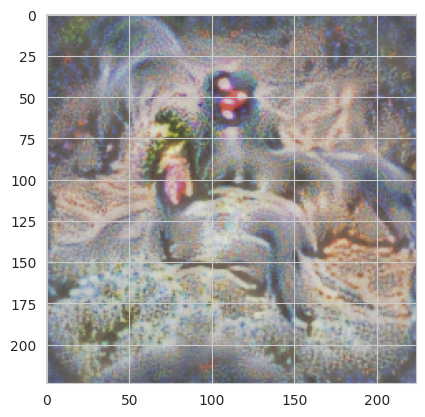

In [42]:
img, _, tstart = feature_visualisation(
    net=target_model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=cfg.eval_lr,
    n_steps=2000,
    init_mean=torch.tensor([]),
    save_list=[],
    target_act_fn=target_act_fn,
    tf=transforms.Compose(image_transforms),
    adam=True,
    grad_clip=1.0,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

In [ ]:
torchvision.utils.save_image(img[0], f"../results/figures/{config_name}_manipulated.jpg")

In [ ]:
after_acc = evaluate(target_model, test_loader, device)

In [ ]:
print("Change in accuracy: ", after_acc - before_acc)